# Trabajo Integrador: DuckDB

## Instalación

In [1]:
%pip install duckdb --upgrade

Note: you may need to restart the kernel to use updated packages.


### Creando conexión

Nos permite establecer una conexión a una base de datos, por defecto, si no especificamos su nombre, la base de datos no persistirá y operará en memoria, por lo tanto no se almacenarán las tablas creadas. Trabajaremos en memoria ya que consideramos que es el fuerte de DUCKDB y su análisis es el pertinente de este trabajo de investigación. 

In [2]:
import duckdb as db

database = db.connect(database=":memory:")


##### Prueba con el dataset. En PostgreSQL almacenaremos archivos de órdenes y sus pagos. En AWS almacenaremos los productos y su categoría. El resto de archivos será almacenado de manera local, algunos en CSV y otros en PARQUET. Esta información se encuentra representada mediante un esquema en la documentación adjunta

In [3]:
%pip install -q kagglehub        
import os
import kagglehub, shutil, pathlib

path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")

os.makedirs("dataset", exist_ok=True)

local_csv_files = [
    "olist_customers_dataset.csv",
    "olist_geolocation_dataset.csv",
    "olist_order_items_dataset.csv",
    "olist_order_reviews_dataset.csv",
    "olist_sellers_dataset.csv",
    ## Estos archivos se almacenaran en PSQL 
    "olist_orders_dataset.csv",
    "olist_order_payments_dataset.csv", 
]

for file_name in local_csv_files:
    shutil.copy(f"{path}/{file_name}", f"dataset/{file_name}")

for file_name in local_csv_files:
    table = pathlib.Path(f"dataset/{file_name}").stem
    database.execute(f"""
        CREATE OR REPLACE TABLE {table} AS
        SELECT * FROM read_csv_auto('dataset/{file_name}');
    """)


Note: you may need to restart the kernel to use updated packages.


#### Verificación básica de la creación de las tablas

In [4]:
for file_name in local_csv_files:
    table = pathlib.Path(f"dataset/{file_name}").stem
    schema = database.sql(f"DESCRIBE {table}")
    print(schema)

┌──────────────────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│       column_name        │ column_type │  null   │   key   │ default │  extra  │
│         varchar          │   varchar   │ varchar │ varchar │ varchar │ varchar │
├──────────────────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ customer_id              │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ customer_unique_id       │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ customer_zip_code_prefix │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ customer_city            │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ customer_state           │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
└──────────────────────────┴─────────────┴─────────┴─────────┴─────────┴─────────┘

┌─────────────────────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│         column_name         │ column_type │  null   │   key   │ default │  extra 

#### Obteniendo los datos de forma remota - Conexión con AWS S3

**NOTA:** Para utilizar AWS S3 es necesario setear las credenciales para acceder al bucket, para eso debemos crear un user en la IAM de AWS, asignarle permisos y finalmente crear las claves de acceso para este usuario. Luego, estas credenciales son obtenidas desde un .env.
Es importante que la región del bucket y del usuario sean la misma.

In [5]:
%pip install python-dotenv
from dotenv import load_dotenv
load_dotenv()  

import os

database.sql("INSTALL httpfs; LOAD httpfs;")

database.sql(f"""
SET s3_region='{os.getenv("AWS_REGION")}';
SET s3_access_key_id='{os.getenv("AWS_ACCESS_KEY_ID")}';
SET s3_secret_access_key='{os.getenv("AWS_SECRET_ACCESS_KEY")}';
""")

Note: you may need to restart the kernel to use updated packages.


## Operaciones

### Creando las tablas con los datos de forma remota

In [6]:
database.sql(f"""
 CREATE OR REPLACE TABLE olist_products_dataset AS
        SELECT * FROM read_csv_auto('s3://ti-quadrelli-ribarov/olist_products_dataset.csv');
""")

database.sql(f"""
 CREATE OR REPLACE TABLE product_category_name_translation AS
        SELECT * FROM read_csv_auto('s3://ti-quadrelli-ribarov/product_category_name_translation.csv');
""")


#### Validación básica de la creación de las tablas con los datos remotos


In [7]:
remote_csv_files  = [
    "olist_products_dataset.csv",
    "product_category_name_translation.csv",
]

for file_name in remote_csv_files:
    table = pathlib.Path(f"dataset/{file_name}").stem
    schema = database.sql(f"DESCRIBE {table}")
    print(schema)

┌────────────────────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│        column_name         │ column_type │  null   │   key   │ default │  extra  │
│          varchar           │   varchar   │ varchar │ varchar │ varchar │ varchar │
├────────────────────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ product_id                 │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ product_category_name      │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ product_name_lenght        │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ product_description_lenght │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ product_photos_qty         │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ product_weight_g           │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ product_length_cm          │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ product_height_cm          │ BIGINT      │ YES     │ NULL    │ 

#### Obteniendo los datos desde PostgreSQL

#### Nota: este paso se podría haber hecho sin DuckDB, mismo desde un manejador de base de datos como DBeaver o con la librería Pandas, sin embargo, nuevamente debido al objetivo de este proyecto, se eligió realizarlo utilizando DuckDB

In [8]:

import os

# Esta celda utiliza duckdb para conectarse a PostgreSQL, crea la base de datos trabajo integrador
# en caso de que no exista 

database.execute("INSTALL postgres;")
database.execute("LOAD postgres;")

try:
    database.execute("DETACH pgadmin;")
except Exception:
    pass

conninfo = f"host={os.getenv('PG_HOST')} port={os.getenv('PG_PORT')} user={os.getenv('PG_USER')} password={os.getenv('PG_PASSWORD')} dbname=postgres"
database.execute(f"ATTACH '{conninfo}' AS pgadmin (TYPE postgres);")

exists = database.execute("""
    SELECT COUNT(*) > 0
    FROM postgres_query(
        'pgadmin',
        $$SELECT 1 FROM pg_database WHERE datname = 'trabajo_integrador'$$
    );
""").fetchone()[0]

if not exists:
    database.execute("""
        CALL postgres_execute(
            'pgadmin',
            $$CREATE DATABASE trabajo_integrador$$,
            use_transaction => false
        );
    """)

database.execute("DETACH pgadmin;")

In [9]:
import pathlib, os

orders_csv   = pathlib.Path("olist_orders_dataset.csv")
payments_dataset = pathlib.Path("olist_order_payments_dataset.csv")
   

conninfo = f"host={os.getenv("PG_HOST")} port={os.getenv("PG_PORT")} user={os.getenv("PG_USER")} password={os.getenv("PG_PASSWORD")} dbname={os.getenv("PG_DB")}"
database.execute(f"ATTACH '{conninfo}' AS pgdb (TYPE postgres);")

#### Creación de tablas

In [10]:
import pathlib

orders_csv = pathlib.Path(path) / "olist_orders_dataset.csv"
payments_dataset = pathlib.Path(path) / "olist_order_payments_dataset.csv"

database.execute(f"""
    DROP TABLE IF EXISTS pgdb.olist_orders;
    CREATE TABLE pgdb.olist_orders AS
    SELECT *
    FROM read_csv_auto('{orders_csv.as_posix()}', HEADER=TRUE);
""")

database.execute(f"""
    DROP TABLE IF EXISTS pgdb.olist_orders_payments;
    CREATE TABLE pgdb.olist_orders_payments AS
    SELECT *
    FROM read_csv_auto('{payments_dataset.as_posix()}', HEADER=TRUE);
""")

In [11]:
postgreee_csv_files  = [
   "olist_orders", 
   "olist_orders_payments"
]

for file_name in postgreee_csv_files:
    table = pathlib.Path(f"dataset/{file_name}").stem
    schema = database.sql(f"DESCRIBE pgdb.{table}")
    print(schema)

┌───────────────────────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│          column_name          │ column_type │  null   │   key   │ default │  extra  │
│            varchar            │   varchar   │ varchar │ varchar │ varchar │ varchar │
├───────────────────────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ order_id                      │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ customer_id                   │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ order_status                  │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ order_purchase_timestamp      │ TIMESTAMP   │ YES     │ NULL    │ NULL    │ NULL    │
│ order_approved_at             │ TIMESTAMP   │ YES     │ NULL    │ NULL    │ NULL    │
│ order_delivered_carrier_date  │ TIMESTAMP   │ YES     │ NULL    │ NULL    │ NULL    │
│ order_delivered_customer_date │ TIMESTAMP   │ YES     │ NULL    │ NULL    │ NULL    │
│ order_estimated_delivery_date 

## Exploracion del dataset

In [12]:
database.sql("SHOW TABLES").df()

,name
0,olist_customers_dataset
1,olist_geolocation_dataset
2,olist_order_items_dataset
3,olist_order_payments_dataset
4,olist_order_reviews_dataset
5,olist_orders_dataset
6,olist_products_dataset
7,olist_sellers_dataset
8,product_category_name_translation


In [13]:
database.sql("SELECT * FROM olist_customers_dataset LIMIT 5").df()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,09790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,01151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,08775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [14]:
print("Filas con nulos:")
database.sql("""
SELECT *
FROM olist_customers_dataset
WHERE
    customer_id IS NULL OR
    customer_unique_id IS NULL OR
    customer_zip_code_prefix IS NULL OR
    customer_city IS NULL OR
    customer_state IS NULL
LIMIT 5
""").df()

Filas con nulos:


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state


In [15]:
database.sql("SELECT * FROM olist_geolocation_dataset LIMIT 5").df()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,01037,-23.545621,-46.639292,sao paulo,SP
1,01046,-23.546081,-46.644820,sao paulo,SP
2,01046,-23.546129,-46.642951,sao paulo,SP
3,01041,-23.544392,-46.639499,sao paulo,SP
4,01035,-23.541578,-46.641607,sao paulo,SP


In [16]:
tables = database.sql("SHOW TABLES").df()['name'].tolist()

for table in tables:
    print(f"Para la tabla: {table}")
    columns = database.sql(f"DESCRIBE {table}").df()['column_name'].tolist()
    where_clause = " OR ".join([f"{col} IS NULL" for col in columns])
    query = f"SELECT 1 FROM {table} WHERE {where_clause} LIMIT 1"
    result = database.sql(query).df()
    if not result.empty:
        print("Tiene nulos")
    else:
        print("NO tiene nulos")


Para la tabla: olist_customers_dataset
NO tiene nulos
Para la tabla: olist_geolocation_dataset
NO tiene nulos
Para la tabla: olist_order_items_dataset
NO tiene nulos
Para la tabla: olist_order_payments_dataset
NO tiene nulos
Para la tabla: olist_order_reviews_dataset
Tiene nulos
Para la tabla: olist_orders_dataset
Tiene nulos
Para la tabla: olist_products_dataset
Tiene nulos
Para la tabla: olist_sellers_dataset
NO tiene nulos
Para la tabla: product_category_name_translation
NO tiene nulos


In [17]:
tablas_con_nulos = ["olist_order_reviews_dataset", "olist_orders_dataset", "olist_products_dataset", "olist_sellers_dataset", "olist_customers_dataset"]
for table in tablas_con_nulos:
    print(f"Tabla: {table}")
    columns = database.sql(f"DESCRIBE {table}").df()['column_name'].tolist()
    where_clause = " OR ".join([f"{col} IS NULL" for col in columns])
    query = f"SELECT * FROM {table} WHERE {where_clause} LIMIT 5"
    df_nulos = database.sql(query).df()
    print(df_nulos)


Tabla: olist_order_reviews_dataset
                          review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score review_comment_title  \
0             4                 None   
1             5                 None   
2             5                 None   
3             5                 None   
4             5                 None   

                              review_comment_message review_creation_date  \
0                                               None           2018-01-18   
1                                               None           2018-03-10   
2                                               None  

In [18]:
total = database.sql("SELECT COUNT(*) AS total FROM olist_order_reviews_dataset").df().iloc[0]['total']
nulos = database.sql("SELECT COUNT(*) AS nulos FROM olist_order_reviews_dataset WHERE review_comment_title IS NULL").df().iloc[0]['nulos']
no_nulos = total - nulos
print(f"review_comment_title nulos: {nulos}")
print(f"review_comment_title no nulos: {no_nulos}")
print(f"Porcentaje de nulos: {nulos / total * 100:.2f}%")

review_comment_title nulos: 87656
review_comment_title no nulos: 11568
Porcentaje de nulos: 88.34%


In [19]:
database.sql("DESCRIBE olist_orders_dataset").df()

,column_name,column_type,null,key,default,extra
0,order_id,VARCHAR,YES,None,None,None
1,customer_id,VARCHAR,YES,None,None,None
2,order_status,VARCHAR,YES,None,None,None
3,order_purchase_timestamp,TIMESTAMP,YES,None,None,None
4,order_approved_at,TIMESTAMP,YES,None,None,None
5,order_delivered_carrier_date,TIMESTAMP,YES,None,None,None
6,order_delivered_customer_date,TIMESTAMP,YES,None,None,None
7,order_estimated_delivery_date,TIMESTAMP,YES,None,None,None


In [20]:
# Obtener la orden más vieja y la última según la columna order_purchase_timestamp
result = database.sql("""
    SELECT 
        MIN(order_purchase_timestamp) AS orden_mas_vieja,
        MAX(order_purchase_timestamp) AS orden_mas_reciente
    FROM olist_orders_dataset
""")
print(result)

┌─────────────────────┬─────────────────────┐
│   orden_mas_vieja   │ orden_mas_reciente  │
│      timestamp      │      timestamp      │
├─────────────────────┼─────────────────────┤
│ 2016-09-04 21:15:19 │ 2018-10-17 17:30:18 │
└─────────────────────┴─────────────────────┘



In [21]:
query = """
SELECT 
    EXTRACT(year FROM order_purchase_timestamp) AS anio,
    COUNT(*) AS cantidad_ordenes
FROM olist_orders_dataset
GROUP BY anio
ORDER BY cantidad_ordenes DESC
LIMIT 3
"""
database.sql(query).df()

,anio,cantidad_ordenes
0,2018,54011
1,2017,45101
2,2016,329


In [22]:
# Obtener la categoría de producto más solicitada
query = """
SELECT product_category_name, COUNT(*) AS cantidad
FROM olist_products_dataset
GROUP BY product_category_name
ORDER BY cantidad DESC
LIMIT 3
"""
database.sql(query).df()

,product_category_name,cantidad
0,cama_mesa_banho,3029
1,esporte_lazer,2867
2,moveis_decoracao,2657


In [23]:
database.sql("""
SELECT customer_city, COUNT(*) AS cantidad
FROM olist_customers_dataset
GROUP BY customer_city
ORDER BY cantidad DESC
LIMIT 1
""").df()

,customer_city,cantidad
0,sao paulo,15540


In [24]:
database.sql(
"""
SELECT seller_city, COUNT(*) AS cantidad_vendedores
FROM olist_sellers_dataset
GROUP BY seller_city
ORDER BY cantidad_vendedores DESC
LIMIT 1
"""
).df()

,seller_city,cantidad_vendedores
0,sao paulo,694


## Consultas

Esta sección consiste en realizar consultas interesantes que podrían ser de utilidad para un negocio que cuenta con el dataset en estudio

¿Cuántos días demora la entrega de las órdenes en los distintos años?

In [25]:
query = """
SELECT 
    EXTRACT(year FROM order_purchase_timestamp) AS anio,
    AVG(DATEDIFF('day', order_purchase_timestamp, order_delivered_customer_date)) AS promedio_dias
FROM olist_orders_dataset
WHERE 
    order_delivered_customer_date IS NOT NULL
GROUP BY anio
ORDER BY anio DESC
"""
database.sql(query).df()

,anio,promedio_dias
0,2018,12.063928
1,2017,12.979045
2,2016,19.687500


¿Cuántos clientes ordenaron en el sitio web?

In [26]:
query = """
SELECT 
    EXTRACT(year FROM olist_orders_dataset.order_purchase_timestamp) AS anio,
    COUNT(DISTINCT olist_customers_dataset.customer_unique_id) AS cantidad_clientes
FROM olist_orders_dataset
JOIN olist_customers_dataset
    ON olist_orders_dataset.customer_id = olist_customers_dataset.customer_id
GROUP BY anio
ORDER BY anio
"""
database.sql(query).df()

,anio,cantidad_clientes
0,2016,326
1,2017,43713
2,2018,52749


¿Cuál fue el cliente con más órdenes?

In [27]:
query = """
SELECT c.customer_unique_id, COUNT(*) AS n_ordenes
FROM olist_orders_dataset o
JOIN olist_customers_dataset c
  ON o.customer_id = c.customer_id
GROUP BY c.customer_unique_id
ORDER BY n_ordenes DESC
LIMIT 10;
"""
database.sql(query).df()

,customer_unique_id,n_ordenes
0,8d50f5eadf50201ccdcedfb9e2ac8455,17
1,3e43e6105506432c953e165fb2acf44c,9
2,1b6c7548a2a1f9037c1fd3ddfed95f33,7
3,6469f99c1f9dfae7733b25662e7f1782,7
4,ca77025e7201e3b30c44b472ff346268,7
5,12f5d6e1cbf93dafd9dcc19095df0b3d,6
6,47c1a3033b8b77b3ab6e109eb4d5fdf3,6
7,de34b16117594161a6a89c50b289d35a,6
8,dc813062e0fc23409cd255f7f53c7074,6
9,63cfc61cee11cbe306bff5857d00bfe4,6


Como parte de un analisis, vamos a crear una tabla nueva con los clientes que realizaron más de 3 pedidos en un año y luego la consultaremos para saber si estos clientes siguieron realizando pedidos o abandonaron la plataforma

In [28]:
query ="""
CREATE TABLE clientes_pedidos_por_año AS
SELECT
    c.customer_unique_id,
    EXTRACT(YEAR FROM o.order_purchase_timestamp) AS año,
    COUNT(*) AS num_pedidos
FROM olist_orders_dataset o
JOIN olist_customers_dataset c
  ON o.customer_id = c.customer_id
GROUP BY c.customer_unique_id, año
ORDER BY c.customer_unique_id, año;
"""
database.sql(query)

In [29]:
query = """
SELECT * 
FROM clientes_pedidos_por_año
"""
database.sql(query).df()

,customer_unique_id,año,num_pedidos
0,0000366f3b9a7992bf8c76cfdf3221e2,2018,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018,1
2,0000f46a3911fa3c0805444483337064,2017,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017,1
4,0004aac84e0df4da2b147fca70cf8255,2017,1
...,...,...,...
96783,fffcf5a5ff07b0908bd4e2dbc735a684,2017,1
96784,fffea47cd6d3cc0a88bd621562a9d061,2017,1
96785,ffff371b4d645b6ecea244b27531430a,2017,1
96786,ffff5962728ec6157033ef9805bacc48,2018,1


Una buena forma de saber por qué estos clientes dejaron la plataforma es observando sus reviews

In [30]:
query = """
CREATE OR REPLACE TABLE clientes_perdidos AS
WITH max_año AS (
    SELECT MAX(año) AS ultimo_año
    FROM clientes_pedidos_por_año
),
activos AS (
    SELECT
        cpa.customer_unique_id,
        cpa.año AS año_activo
    FROM clientes_pedidos_por_año cpa
    WHERE cpa.num_pedidos > 3
),
posteriores AS (
    SELECT
        a.customer_unique_id,
        MIN(cpa.año) AS primer_año_posterior
    FROM activos a
    JOIN clientes_pedidos_por_año cpa
      ON a.customer_unique_id = cpa.customer_unique_id
     AND cpa.año > a.año_activo
     AND cpa.num_pedidos > 0
    GROUP BY a.customer_unique_id, a.año_activo
)

SELECT
    a.customer_unique_id,
    a.año_activo
FROM activos a
JOIN max_año m
  ON 1=1
LEFT JOIN posteriores p
  ON a.customer_unique_id = p.customer_unique_id
 AND a.año_activo = p.primer_año_posterior - 1
WHERE
    a.año_activo < m.ultimo_año
  AND p.primer_año_posterior IS NULL;
"""
database.sql(query)

In [31]:
query = """
SELECT *
FROM clientes_perdidos
"""
database.sql(query).df()

,customer_unique_id,año_activo
0,12f5d6e1cbf93dafd9dcc19095df0b3d,2017
1,25a560b9a6006157838aab1bdbd68624,2017
2,83e7958a94bd7f74a9414d8782f87628,2017
3,a239b8e2fbce33780f1f1912e2ee5275,2017
4,a7657330b1c135f3acd420326e335b2c,2017
5,b08fab27d47a1eb6deda07bfd965ad43,2017
6,b8b3c435a58aebd788a477bed8342910,2017
7,ec7f1811826ab04a27a92197bc40c888,2017
8,f34cd7fd85a1f8baff886edf09567be3,2017
9,f64ec6d8dd29940264cd0bbb5ecade8a,2017


In [32]:
query = """
SELECT 
    cp.customer_unique_id,
    cp.año_activo AS año,
    r.review_score AS puntaje,
    r.review_comment_message AS comentario
FROM clientes_perdidos cp
JOIN olist_customers_dataset c
    ON cp.customer_unique_id = c.customer_unique_id
JOIN olist_orders_dataset o
    ON c.customer_id = o.customer_id
LEFT JOIN olist_order_reviews_dataset r
    ON o.order_id = r.order_id
    AND EXTRACT(YEAR FROM o.order_purchase_timestamp) = cp.año_activo
WHERE r.review_comment_message IS NOT NULL
GROUP BY cp.customer_unique_id, cp.año_activo, r.review_score, r.review_comment_message
ORDER BY cp.customer_unique_id, cp.año_activo
"""
database.sql(query).df()


,customer_unique_id,año,puntaje,comentario
0,12f5d6e1cbf93dafd9dcc19095df0b3d,2017,5,Super recomendo essa loja! Recebi bem antes do...
1,12f5d6e1cbf93dafd9dcc19095df0b3d,2017,5,Recebi antes do prazo de entrega informado e o...
2,12f5d6e1cbf93dafd9dcc19095df0b3d,2017,5,Recebi bem antes do prazo informado e o produt...
3,12f5d6e1cbf93dafd9dcc19095df0b3d,2017,5,Recomendo a loja! Produto entregue dentro do p...
4,83e7958a94bd7f74a9414d8782f87628,2017,5,"Recebi muito bem embalado, o produto é mais bo..."
5,83e7958a94bd7f74a9414d8782f87628,2017,5,"Adorei o produto, condiz com as imagens, a ent..."
6,83e7958a94bd7f74a9414d8782f87628,2017,5,Uahlll! Recebi minha compra 30 dias antes do p...
7,a239b8e2fbce33780f1f1912e2ee5275,2017,5,Recomendo para outros
8,b08fab27d47a1eb6deda07bfd965ad43,2017,5,Perfeito para iniciantes.\r\n
9,b08fab27d47a1eb6deda07bfd965ad43,2017,5,Minha esposa amou.


## Benchmark - En esta sección compararemos la performance de DuckDB contra su competidor más directo SQLite. Ambos utilizan a bases de datos embebidas.

### Realizaremos pruebas utilizando la base de datos almacenada en disco y en memoria.Las pruebas fueron realizadas en una Mac con M3 y 16GB de RAM. 

In [33]:
import pandas as pd

# En esta celda obtendremos todas las tablas que están en la bdd. 
# Para luego obtener las que tienen más filas, más columnas y las más pesadas en tamaño.
# Utilizaremos estas tablas para realizar la comparación entre DuckDB y SQLite

all_tables = [r[0] for r in database.sql("SHOW TABLES").fetchall()]

table_data = []
# Se itera e las tablas, se obtienen los valores a medir y se guardan los resultados
for table in all_tables:
    rows_amount = database.sql(f"SELECT COUNT(*) FROM {table}").fetchone()[0]
    cols_amount = len(database.sql(f"PRAGMA table_info({table})").fetchall())
    csv = pathlib.Path("dataset") / f"{table}.csv"
    size = csv.stat().st_size if csv.exists() else 'En S3'
    table_data.append((table, rows_amount, cols_amount, size))

meta_df = pd.DataFrame(table_data, columns=["table", "rows", "cols", "size_bytes"])
# Las dos tablas que no están locales se ven en los resultados como 'En S3'
# Sin embargo, lo verificamos y su peso no es mayor a la tabla de geolocalización
display(meta_df)

meta_df["size_num"] = pd.to_numeric(meta_df["size_bytes"], errors="coerce")
meta_df["size_num"] = meta_df["size_num"].fillna(0)

most_rows = meta_df.loc[meta_df.rows.idxmax(), "table"]
most_cols = meta_df.loc[meta_df.cols.idxmax(), "table"]
most_size = meta_df.loc[meta_df.size_num.idxmax(), "table"]

benchmark_tables = {
    "más_filas":  most_rows,
    "más_cols":   most_cols,
    "csv_pesado": most_size,
}

print(f"Tablas elegidas para el benchmark: {benchmark_tables}")



,table,rows,cols,size_bytes
0,clientes_pedidos_por_año,96788,3,En S3
1,clientes_perdidos,10,2,En S3
2,olist_customers_dataset,99441,5,9033957
3,olist_geolocation_dataset,1000163,5,61273883
4,olist_order_items_dataset,112650,7,15438671
5,olist_order_payments_dataset,103886,5,5777138
6,olist_order_reviews_dataset,99224,7,14451670
7,olist_orders_dataset,99441,8,17654914
8,olist_products_dataset,32951,9,En S3
9,olist_sellers_dataset,3095,4,174703


Tablas elegidas para el benchmark: {'más_filas': 'olist_geolocation_dataset', 'más_cols': 'olist_products_dataset', 'csv_pesado': 'olist_geolocation_dataset'}


## Ejecución en memoria

In [34]:
import time, gc, statistics as stats
import  sqlite3, duckdb

# Elegimos consultas basicas pero pesadas para evaluar el rendimiento de ambos motores
QUERIES = {
    # Cuenta el número de filas de la tabla
    "row_count" : "SELECT COUNT(*) FROM t",
    # Agrupa por una columna y cuenta el número de filas en cada grupo
    "group_all" : "SELECT 1 g, COUNT(*) FROM t GROUP BY 1",
    # Selecciona filas al azar
    "filter"    : "SELECT * FROM t WHERE random() < 0.01",
    # Realiza un join de la tabla consigo misma
    "self_join" : "SELECT a.* FROM t a JOIN t b ON a.rowid = b.rowid LIMIT 1000",
}

# Esta funcion ejecuta las consultas 5 veces y luego toma el tiempo para quedarse
# con el promedio de esos tiempos
def avg_time(factory, query_to_execute):                 
    times = []
    for i in range(5):
        # El modulo gc permite invocar funciones de garbage collector para que las pruebas sean
        # más "justas"
        gc.collect()

        # Esta fábrica se usara pa ejecutar la query con la BD nueva o la existente, 
        # de formma de poder variar las pruebas
        connection = factory()    

        # La funcion perf_counter permite medir el tiempo de ejecución                     
        initial_time = time.perf_counter()                
        query_to_execute(connection)

        # Se agrega el tiempo de ejecución. Tiempo inicial menos actual                           
        times.append(time.perf_counter() - initial_time)   

        # Si la conexión es de las cold, se cierra
        if getattr(connection, "_close_after_run", False):   
            connection.close()

    return stats.mean(times)

def add_row(rows, table, query, state, duck_sec, sqlite_sec):
    rows.append({
        "tabla": table,
        "consulta": query,
        "estado": state,                     
        "tiempo duckdb (ms)":  round(duck_sec   * 1_000, 3),
        "tiempo sqlite (ms)":  round(sqlite_sec * 1_000, 3),
    })

bench_rows = []

for table_characteristics, table in benchmark_tables.items():      
    df = database.sql(f"SELECT * FROM {table}").fetchdf()

    # Esta parte nos parecio un agregado interesante a testear.
    # Ya que, no es lo mismo que la conexión con la base de datps esté ya activa a tener que levantarla
    # desde 0 para ejecutar las consultas, entonces lo que hicimos fue crear una fábrica
    # que permita utilizar dos base de datos, una "fria" que se inicia cada vez que se ejcuta
    # la consulta y otra "caliente" que está siempre activa y se reutiliza.
    # Esto tambien permite ver si hay diferencias en los distitnos tipos de bases,
    # ya sea en cachés u otros datos que almacenen los motores para optimizar las consutlas.

    # Definición de bases "frias"

    cold_duck = lambda: duckdb.connect(":memory:")
    cold_sql  = lambda: sqlite3.connect(":memory:")
    cold_duck._close_after_run = True           
    cold_sql._close_after_run  = True          

    duck_ins_cold = avg_time(
        cold_duck,
        lambda c: (c.register("src", df),
                   c.execute("CREATE TABLE t AS SELECT * FROM src"))
    )
    sqlite_ins_cold = avg_time(
        cold_sql,
        lambda c: df.to_sql("t", c, if_exists="replace", index=False)
    )

    # Definición de bases "calientes"

    warm_duck = duckdb.connect(":memory:")       
    warm_sql  = sqlite3.connect(":memory:")      
    warm_duck.register("src", df)
    warm_duck.execute("CREATE TABLE t AS SELECT * FROM src")
    df.to_sql("t", warm_sql, if_exists="replace", index=False)

    duck_ins_warm = avg_time(lambda: warm_duck,
                             lambda c: c.execute("DELETE FROM t; INSERT INTO t SELECT * FROM src;"))
    sqlite_ins_warm = avg_time(lambda: warm_sql,
                               lambda c: (c.execute("DELETE FROM t"),
                                          df.to_sql("t", c, if_exists="append", index=False)))

    add_row(bench_rows, table_characteristics, "insert", "cold",
            duck_ins_cold, sqlite_ins_cold)
    add_row(bench_rows, table_characteristics, "insert", "warm",
            duck_ins_warm, sqlite_ins_warm)

    for query_name, query_to_exe in QUERIES.items():

        duck_q_cold = avg_time(
            cold_duck,
            lambda c: (c.register("src", df),
                       c.execute("CREATE TABLE t AS SELECT * FROM src"),
                       c.execute(query_to_exe).fetchall())
        )

        cold_sql_factory = lambda: sqlite3.connect(":memory:")
        cold_sql_factory._close_after_run = True

        sqlite_q_cold = avg_time(
            cold_sql_factory,
            lambda c: (
                df.to_sql("t", c, if_exists="replace", index=False),
                c.execute(query_to_exe).fetchall()        
            )
        )

        duck_q_warm = avg_time(lambda: warm_duck,
                               lambda c: c.execute(query_to_exe).fetchall())
        sqlite_q_warm = avg_time(lambda: warm_sql,
                                 lambda c: c.execute(query_to_exe).fetchall())    

        add_row(bench_rows, table_characteristics, query_name, "cold",
                duck_q_cold,   sqlite_q_cold)
        add_row(bench_rows, table_characteristics, query_name, "warm",
                duck_q_warm,   sqlite_q_warm)

    warm_duck.close(); warm_sql.close()

res_df = pd.DataFrame(bench_rows)

# Para que sea más visual, en caso que haya ganado DuckDB, se mostrará el valor positivo
# y en caso que haya ganado SQLite, se mostrará el valor negativo de la diferencia.
def diff(row):
    duckdb_time, sqlite_time = row["tiempo duckdb (ms)"], row["tiempo sqlite (ms)"]
    if duckdb_time < sqlite_time:                 
        return round(sqlite_time / duckdb_time, 2)
    else:                   
        return - round(duckdb_time / sqlite_time, 2)

res_df["diferencia (en veces más rápido)"] = res_df.apply(diff, axis=1)
display(res_df)

,tabla,consulta,estado,tiempo duckdb (ms),tiempo sqlite (ms),diferencia (en veces más rápido)
0,más_filas,insert,cold,167.006,1050.591,6.29
1,más_filas,insert,warm,174.433,1076.863,6.17
2,más_filas,row_count,cold,166.205,1052.681,6.33
3,más_filas,row_count,warm,1.703,1.149,-1.48
4,más_filas,group_all,cold,166.827,1187.252,7.12
5,más_filas,group_all,warm,2.371,139.170,58.70
6,más_filas,filter,cold,178.758,1596.533,8.93
7,más_filas,filter,warm,14.877,534.620,35.94
8,más_filas,self_join,cold,186.651,1046.988,5.61
9,más_filas,self_join,warm,23.196,0.915,-25.35


### Visualización de los resultados obtenidos

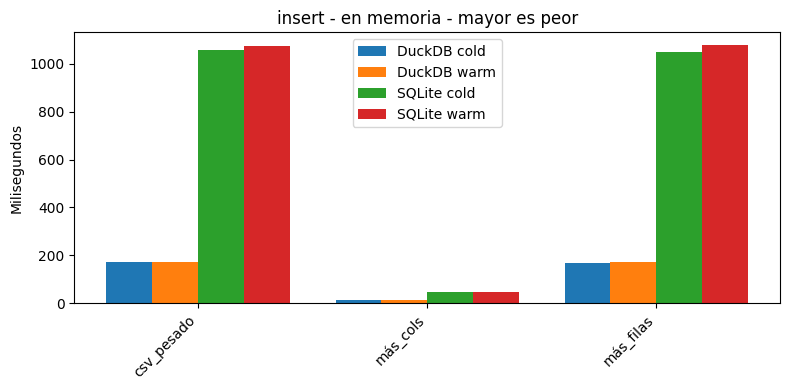

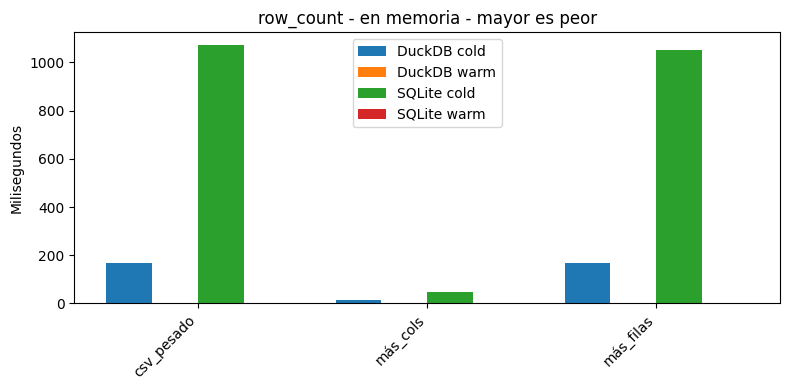

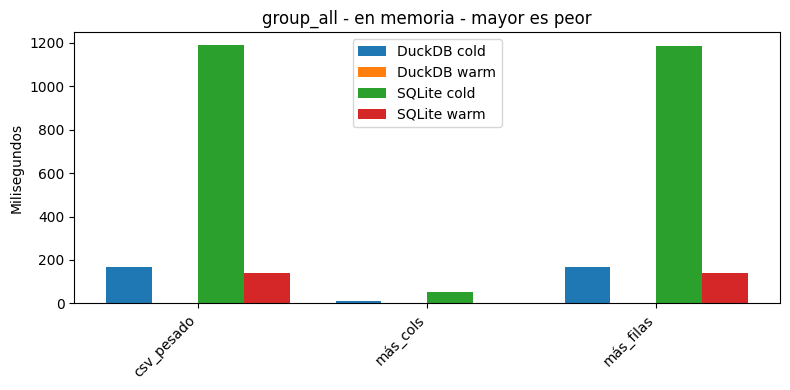

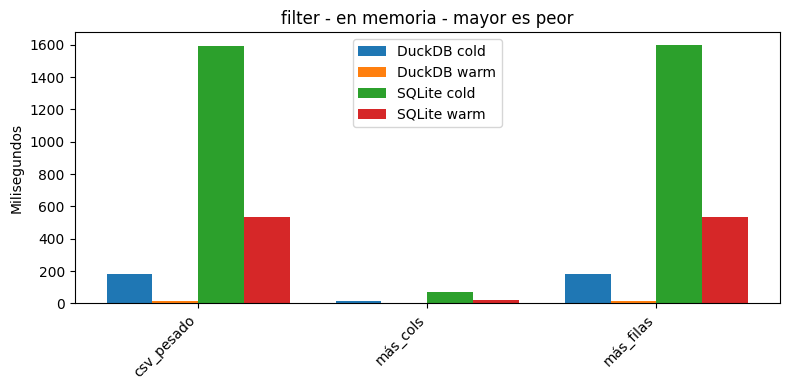

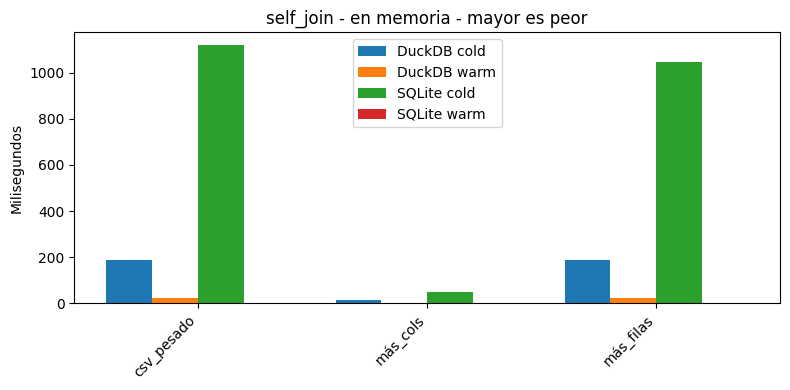

In [35]:
import numpy as np
import matplotlib.pyplot as plt

for query in res_df["consulta"].unique():
    sl = res_df[res_df["consulta"] == query]
    if sl.empty:
        continue

    sl = sl.sort_values(["tabla", "estado"])
    x = np.arange(len(sl) // 2)          
    width = 0.2

    fig, ax = plt.subplots(figsize=(8,4))

    cold_d = sl[sl["estado"]=="cold"]["tiempo duckdb (ms)"].values
    warm_d = sl[sl["estado"]=="warm"]["tiempo duckdb (ms)"].values
    cold_s = sl[sl["estado"]=="cold"]["tiempo sqlite (ms)"].values
    warm_s = sl[sl["estado"]=="warm"]["tiempo sqlite (ms)"].values

    ax.bar(x - 1.5*width, cold_d, width, label="DuckDB cold")
    ax.bar(x - 0.5*width, warm_d, width, label="DuckDB warm")
    ax.bar(x + 0.5*width, cold_s, width, label="SQLite cold")
    ax.bar(x + 1.5*width, warm_s, width, label="SQLite warm")

    ax.set_xticks(x)
    ax.set_xticklabels(sl["tabla"].unique(), rotation=45, ha="right")
    ax.set_ylabel("Milisegundos")
    ax.set_title(f"{query} - en memoria - mayor es peor")
    ax.legend()
    plt.tight_layout()
    plt.show()

## Ejecución en disco


In [36]:
import tempfile

rows_disk = []

for key, tbl in benchmark_tables.items():
    df = database.sql(f"SELECT * FROM {tbl}").fetchdf()
    
    # Creamos archivos temporales para DuckDB y SQLite 
    # para que sea más "justo"
    
    duck_file   = pathlib.Path(tempfile.mktemp(suffix=".duckdb"))
    sqlite_file = pathlib.Path(tempfile.mktemp(suffix=".sqlite"))

    # inserción única
    duckdb.connect(duck_file).execute("CREATE TABLE t AS SELECT * FROM df").close()
    df.to_sql("t", sqlite3.connect(sqlite_file), if_exists="replace", index=False)

    # en este caso, no tiene sentido diferenciar entre conexión activa o no,
    # ya que estamos escribiendo en disco, por lo que no hay caché 

    duckdb_connection = duckdb.connect(duck_file)
    sqlite_connection = sqlite3.connect(sqlite_file)

    for qname, qsql in QUERIES.items():
        initial_time = time.perf_counter(); duckdb_connection.execute(qsql).fetchall(); duck_ms = (time.perf_counter()-initial_time)*1e3
        initial_time = time.perf_counter(); sqlite_connection.execute(qsql).fetchall(); sqlite_ms = (time.perf_counter()-initial_time)*1e3
        rows_disk.append({"tabla": key, "consulta": qname,
                          "tiempo duckdb (ms)": round(duck_ms,3),
                          "tiempo sqlite (ms)": round(sqlite_ms,3)})

    # Acá cerramos las conexiones como buena práctica, pero no es estrictamente necesario

    duckdb_connection.close(); sqlite_connection.close()
    duck_file.unlink(); sqlite_file.unlink()

res_disk = pd.DataFrame(rows_disk)

def diff(row):
    duckdb_time = row["tiempo duckdb (ms)"]
    sqlite_time = row["tiempo sqlite (ms)"]
    if duckdb_time < sqlite_time:                 
        return round(sqlite_time / duckdb_time, 2)
    else:                   
        return - round(duckdb_time / sqlite_time, 2)


res_disk["diferencia"] = res_disk.apply(diff, axis=1)

display(res_disk)

,tabla,consulta,tiempo duckdb (ms),tiempo sqlite (ms),diferencia
0,más_filas,row_count,0.345,11.132,32.27
1,más_filas,group_all,1.148,151.870,132.29
2,más_filas,filter,16.315,549.020,33.65
3,más_filas,self_join,31.507,0.943,-33.41
4,más_cols,row_count,0.357,1.175,3.29
5,más_cols,group_all,0.585,3.933,6.72
6,más_cols,filter,4.647,23.530,5.06
7,más_cols,self_join,5.577,1.287,-4.33
8,csv_pesado,row_count,0.353,10.938,30.99
9,csv_pesado,group_all,1.481,148.245,100.10


### Visualización de los resultados obtenidos

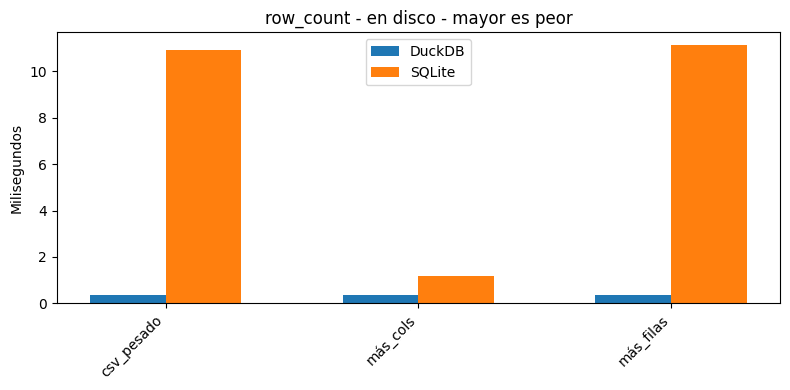

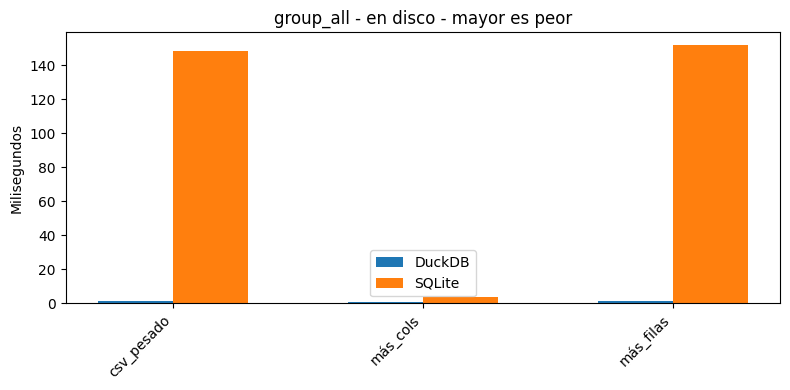

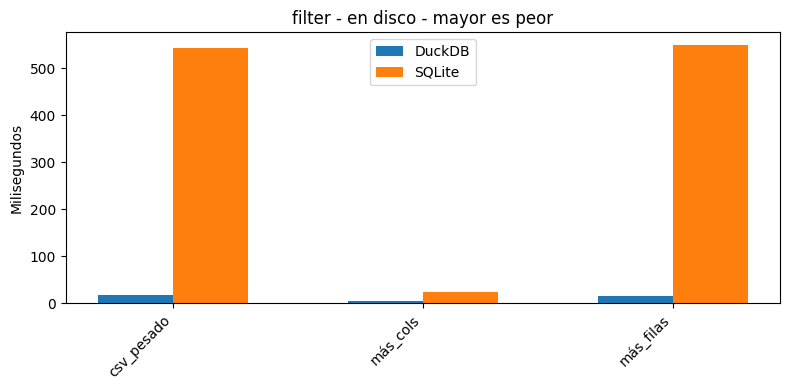

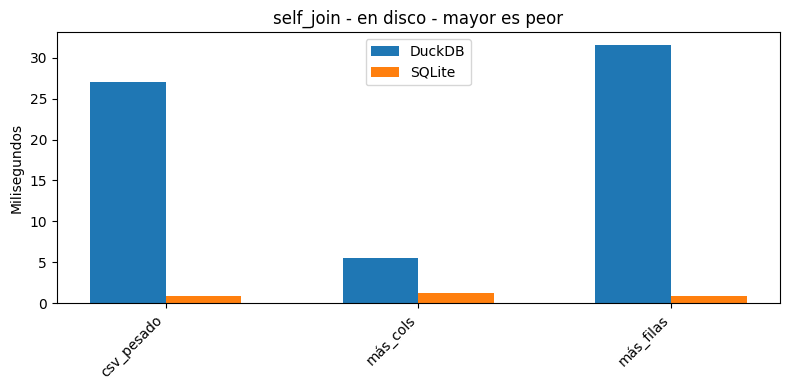

In [37]:
for query in res_disk["consulta"].unique():
    sl = res_disk[res_disk["consulta"] == query].sort_values("tabla")
    x  = np.arange(len(sl))
    width = 0.3

    fig, ax = plt.subplots(figsize=(8,4))
    ax.bar(x - width/2, sl["tiempo duckdb (ms)"], width, label="DuckDB")
    ax.bar(x + width/2, sl["tiempo sqlite (ms)"], width, label="SQLite")

    ax.set_xticks(x)
    ax.set_xticklabels(sl["tabla"], rotation=45, ha="right")
    ax.set_ylabel("Milisegundos")
    ax.set_title(f"{query} - en disco - mayor es peor")
    ax.legend()
    plt.tight_layout()
    plt.show()